03717357-Gregory Ollivierre - with log10 scaling

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
pd.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("data_a.csv").drop('Unnamed: 0',axis=1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [4]:
#lets check each of the text based columns and make sure no wierd data
for col in df.columns:
    if df[col].dtype == 'object':
        print(col,df[col].unique())

cut ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [5]:
# lets check all rows for missing data
df.isnull().any().any()

False

In [6]:
#ok so lets encode those object columns
#lets assume an Ideal cut has a higher wieighting than a fair cut
df2 = df.copy()
df2['cut'] = df['cut'].apply(lambda x: {"Ideal":4,"Premium":3,"Very Good":2,"Good":1,"Fair":0}[x])
df2['color'] = df['color'].apply(lambda x : {'D':6,'E':5,'F':4,'G':3,'H':2,'I':1,'J':0}[x])
df2['clarity'] = df['clarity'].apply(lambda x : {'I1':0,'SI2':1,'SI1':2,'VS2':3,'VS1':4,'VVS2':5,'VVS1':6,'IF':7}[x])
df2.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null int64
color      53940 non-null int64
clarity    53940 non-null int64
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(4)
memory usage: 4.1 MB


In [8]:
# lets have a look at the relative distributions
df2.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,2.904097,3.405803,3.051020,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.116600,1.701105,1.647136,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,2.000000,2.000000,2.000000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,3.000000,3.000000,3.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,4.000000,5.000000,4.000000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [9]:
# ok so Price and a few other columns seem to have a different relative scale to the others.
# Lets Apply the log function to each column. 
for col in df2.columns:
    df2[col] = np.log(df2[col]+1) # +1 to avoid log of zero
df2.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.555323,1.306589,1.383571,1.312229,4.138888,4.067576,7.787424,1.892978,1.893550,1.500873
std,0.244854,0.364886,0.488959,0.427790,0.022900,0.037759,1.014111,0.166140,0.165168,0.153685
min,0.182322,0.000000,0.000000,0.000000,3.784190,3.784190,5.789960,0.000000,0.000000,0.000000
25%,0.336472,1.098612,1.098612,1.098612,4.127134,4.043051,6.857514,1.742219,1.743969,1.363537
50%,0.530628,1.386294,1.386294,1.386294,4.139955,4.060443,7.784057,1.902108,1.903599,1.510722
75%,0.712950,1.609438,1.791759,1.609438,4.151040,4.094345,8.580215,2.020222,2.020222,1.617406
max,1.793425,1.609438,1.945910,2.079442,4.382027,4.564348,9.842888,2.463002,4.092677,3.490429


In [10]:
# ok so that looks alot better now in terms of relative scale. Lets setup the target and inputs
df2 = df2.sample(frac=1) # shuffle
target = df2['price']
inputs = df2.drop(['price'],axis=1)

In [11]:
inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 41020 to 8389
Data columns (total 9 columns):
carat      53940 non-null float64
cut        53940 non-null float64
color      53940 non-null float64
clarity    53940 non-null float64
depth      53940 non-null float64
table      53940 non-null float64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(9)
memory usage: 4.1 MB


In [12]:
X = inputs.values
y = target.values
k_fold = KFold(n_splits=5)
k_fold.get_n_splits(X)
errors = []
for train_idx, test_idx in k_fold.split(X):
    train_X, test_X = X[train_idx], X[test_idx]
    train_y, test_y = y[train_idx], y[test_idx]
    lr = linear_model.Ridge()
    lr.fit(train_X, train_y)
    predictions = lr.predict(test_X)
    error = np.mean(np.abs(predictions - test_y)/test_y * 100) # mean average percentage error
    errors.append(error)
print(np.mean(errors))
print(np.std(errors))
print(errors)

1.6044188998832845
0.022643204431434243
[1.6344639165541084, 1.6265320609630194, 1.574280396234076, 1.5901597406762187, 1.5966583849889995]


This average percentage error is pretty good and low....as is the standard deviation.

[9/9] features ████████████████████ Time elapsed: 0 seconds

(<matplotlib.figure.Figure at 0x1daeae37160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1daeaeeb0f0>)

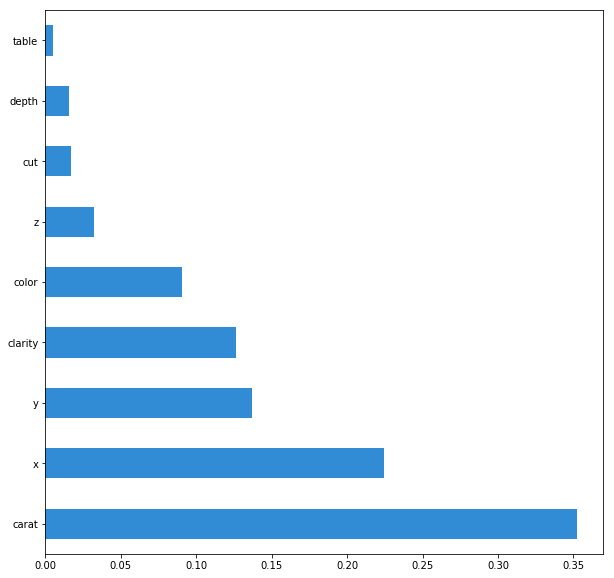

In [13]:
model = InMemoryModel(lr.predict, examples = X)
interpreter = Interpretation(X, feature_names=inputs.columns)
matplotlib.rcParams['figure.figsize'] = [10, 10]
interpreter.feature_importance.plot_feature_importance(model)

so we see that carat size is buy and large the most significant feature confirming our intuition that larger carats cost more money. Closely related features that affect price are the width and length.